In [2]:
import pandas as pd
import pandas_ta as ta
import numpy as np
from bs4 import BeautifulSoup as bs
import sqlite3
from datetime import date
from datetime import datetime as dt
import hashlib
import sys
import os
import locale
import re
import requests as rq
import wbdata as wb
from contextlib import contextmanager
import pytz
from datetime import timedelta
from currency_converter import CurrencyConverter
cc=CurrencyConverter()
from matplotlib import pyplot as plt
from sklearn import preprocessing as prep
import numpy as np

project_dir = '/home/mi/Dropbox/prog/python/tradeDB'
os.chdir(project_dir)

from importlib import reload
#from workers import sql
from workers import api
#from workers.common import read_json, hash_table
import tradeDB

In [3]:
stock= tradeDB.Trader()

In [4]:
stock.get(tab='STOCK',components='wig20')
ind = stock.to_str('symbol')
stock.get(tab='STOCK',symbol=ind, start_date='1-01-2010', currency='USD')


In [5]:
wig20=tradeDB.Trader()
wig20.get(tab='INDEXES',symbol='wig20')
spx=tradeDB.Trader()
spx.get(tab='INDEXES',symbol='^spx')

Date range set to last working day.
Select start_date and/or end_date if you want different dates.
Date range set to last working day.
Select start_date and/or end_date if you want different dates.


In [6]:
stock = stock+spx+wig20

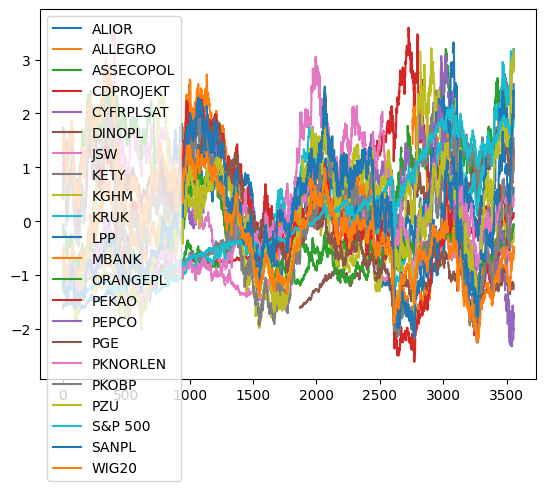

In [7]:
stock.plot()

In [12]:
pkn=tradeDB.Trader()
pkn.get(tab='stock',symbol='pkn',columns='-indexes;-industry;-info', start_date='1-1-2020')

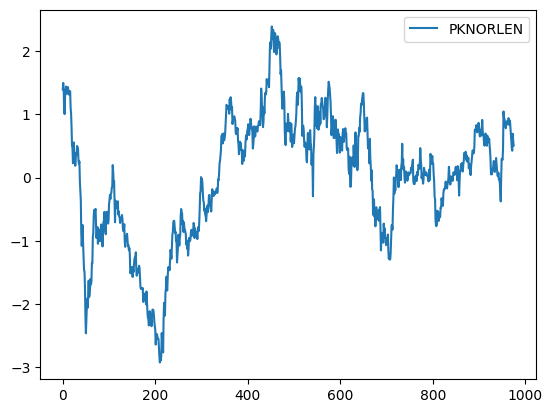

In [13]:
pkn.data['sma']=ta.sma(pkn.data['val'],length=100)
pkn.plot()

In [14]:
pkn.data

,high,vol,from_date,name,open,date,industry,symbol,to_date,info,val,low,country,indexes,sma
0,63.6400,2193694,2009-12-30,PKNORLEN,63.3000,2023-11-16,NULL,PKN,2023-11-17,NULL,62.6000,62.5700,PL,WIG,NaN
1,63.6400,2193694,2009-12-30,PKNORLEN,63.3000,2023-11-16,NULL,PKN,2023-11-17,NULL,62.6000,62.5700,PL,WIG20,NaN
2,65.2000,2376026,2009-12-30,PKNORLEN,65.0000,2023-11-15,NULL,PKN,2023-11-17,NULL,63.2300,62.9600,PL,WIG,NaN
3,65.2000,2376026,2009-12-30,PKNORLEN,65.0000,2023-11-15,NULL,PKN,2023-11-17,NULL,63.2300,62.9600,PL,WIG20,NaN
4,64.4400,2072087,2009-12-30,PKNORLEN,62.0600,2023-11-14,NULL,PKN,2023-11-17,NULL,64.2700,62.0100,PL,WIG,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1947,71.2757,886384,2009-12-30,PKNORLEN,71.1614,2020-01-03,NULL,PKN,2023-11-17,NULL,70.5191,69.7625,PL,WIG20,59.952308
1948,71.8029,783654,2009-12-30,PKNORLEN,71.1614,2020-01-02,NULL,PKN,2023-11-17,NULL,71.5393,70.5033,PL,WIG,60.291903
1949,71.8029,783654,2009-12-30,PKNORLEN,71.1614,2020-01-02,NULL,PKN,2023-11-17,NULL,71.5393,70.5033,PL,WIG20,60.631498
1950,71.0788,526813,2009-12-30,PKNORLEN,70.7335,2019-12-30,NULL,PKN,2023-11-17,NULL,70.6017,70.1246,PL,WIG,60.980144


In [15]:
pkn.data.reindex(columns=['name','sma'])

,name,sma
0,PKNORLEN,NaN
1,PKNORLEN,NaN
2,PKNORLEN,NaN
3,PKNORLEN,NaN
4,PKNORLEN,NaN
...,...,...
1947,PKNORLEN,59.952308
1948,PKNORLEN,60.291903
1949,PKNORLEN,60.631498
1950,PKNORLEN,60.980144


In [ ]:
help(ta.sma)

Help on function sma in module pandas_ta.overlap.sma:

sma(close, length=None, talib=None, offset=None, **kwargs)
    Simple Moving Average (SMA)
    
    The Simple Moving Average is the classic moving average that is the equally
    weighted average over n periods.
    
    Sources:
        https://www.tradingtechnologies.com/help/x-study/technical-indicator-definitions/simple-moving-average-sma/
    
    Calculation:
        Default Inputs:
            length=10
        SMA = SUM(close, length) / length
    
    Args:
        close (pd.Series): Series of 'close's
        length (int): It's period. Default: 10
        talib (bool): If TA Lib is installed and talib is True, Returns the TA Lib
            version. Default: True
        offset (int): How many periods to offset the result. Default: 0
    
    Kwargs:
        adjust (bool): Default: True
        presma (bool, optional): If True, uses SMA for initial value.
        fillna (value, optional): pd.DataFrame.fillna(value)
     